# Banana Slug Predictor Using MaxEnt and Synthetic Data

In [1]:
import elapid as ela
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import warnings

In [2]:
# import data
df = pd.read_csv('synthetic_banana_slug_data.csv')

In [3]:
df

,temperature,precipitation,elevation,forest_cover,humidity,class
0,12.122457,1610.704323,185.873166,97.985150,84.100733,1
1,10.579918,728.792421,433.979357,84.017474,62.883813,0
2,10.919384,1176.951078,971.038018,9.915048,83.751985,0
3,15.827733,508.186341,143.284026,44.231678,72.928550,0
4,13.600525,1526.899500,174.940393,90.985938,88.733569,1
...,...,...,...,...,...,...
3295,17.590814,931.325038,283.094784,28.858842,94.118797,0
3296,10.835976,828.591124,1011.524575,58.444877,30.860020,0
3297,8.261228,819.182181,519.844879,68.738471,76.313212,0
3298,19.511501,1704.842348,661.095771,2.526536,15.980361,0


In [4]:
# Split into features and target
X = df.drop('class', axis=1)
y = df['class']

In [5]:
X.describe()

,temperature,precipitation,elevation,forest_cover,humidity
count,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000
mean,14.613105,1045.897137,838.742330,53.232508,52.434188
std,7.756418,494.944624,506.804517,23.681735,23.662450
min,-13.656415,-980.322223,11.735008,1.728972,2.056382
25%,9.293438,709.529760,468.083718,34.992325,33.570755
50%,14.053024,1059.740031,741.007031,52.744438,51.603854
75%,19.685044,1399.414561,1116.214602,71.958401,71.079910
max,40.739197,2879.839419,3814.587691,99.954896,99.962533


In [6]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [7]:
# Calculate class counts
n_presence_train = sum(y_train)
n_background_train = sum(1-y_train)

In [8]:
# Create sample weights - this helps with class imbalance
presence_weight = 1.0 
background_weight = n_presence_train / n_background_train  
sample_weight = np.where(y_train == 1, presence_weight, background_weight)

In [9]:
# Train Model
model = ela.MaxentModel(
    beta_multiplier=1.5,  # Regularization strength
    feature_types="lpqht"  # Linear, product, quadratic, hinge, threshold
)

In [10]:
# Fit the model
model.fit(X_train, y_train, sample_weight=sample_weight)

MaxentModel(feature_types=['linear', 'product', 'quadratic', 'hinge',
                           'threshold'])

In [11]:
# Evaluate on test data
y_prob = model.predict_proba(X_test)[:, 1]  # Get probability of class 1 (presence)

In [12]:
# Convert probabilities to binary predictions using a threshold 
# Binary classifications needed for model evalutation- will use probability for banana slug analysis
threshold = 0.5
y_pred_binary = (y_prob >= threshold).astype(int)

In [13]:
# Performance metrics
auc = metrics.roc_auc_score(y_test, y_prob)
accuracy = metrics.accuracy_score(y_test, y_pred_binary)
precision = metrics.precision_score(y_test, y_pred_binary)
recall = metrics.recall_score(y_test, y_pred_binary)

print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

AUC: 0.9910
Accuracy: 0.9747
Precision: 0.8736
Recall: 0.8444


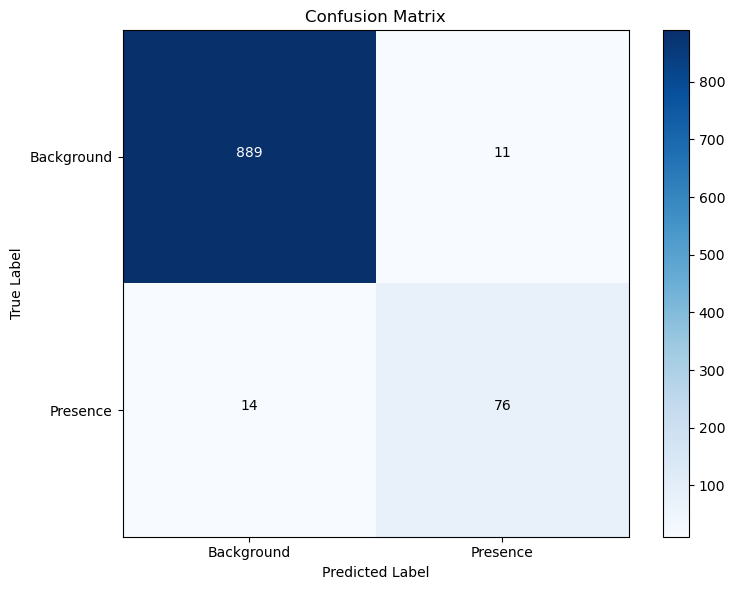

In [14]:
# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Background', 'Presence'])
plt.yticks(tick_marks, ['Background', 'Presence'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()

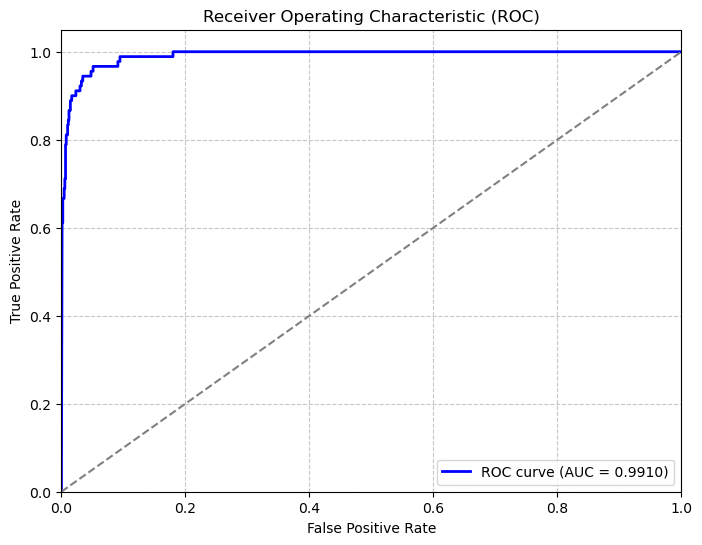

In [15]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)

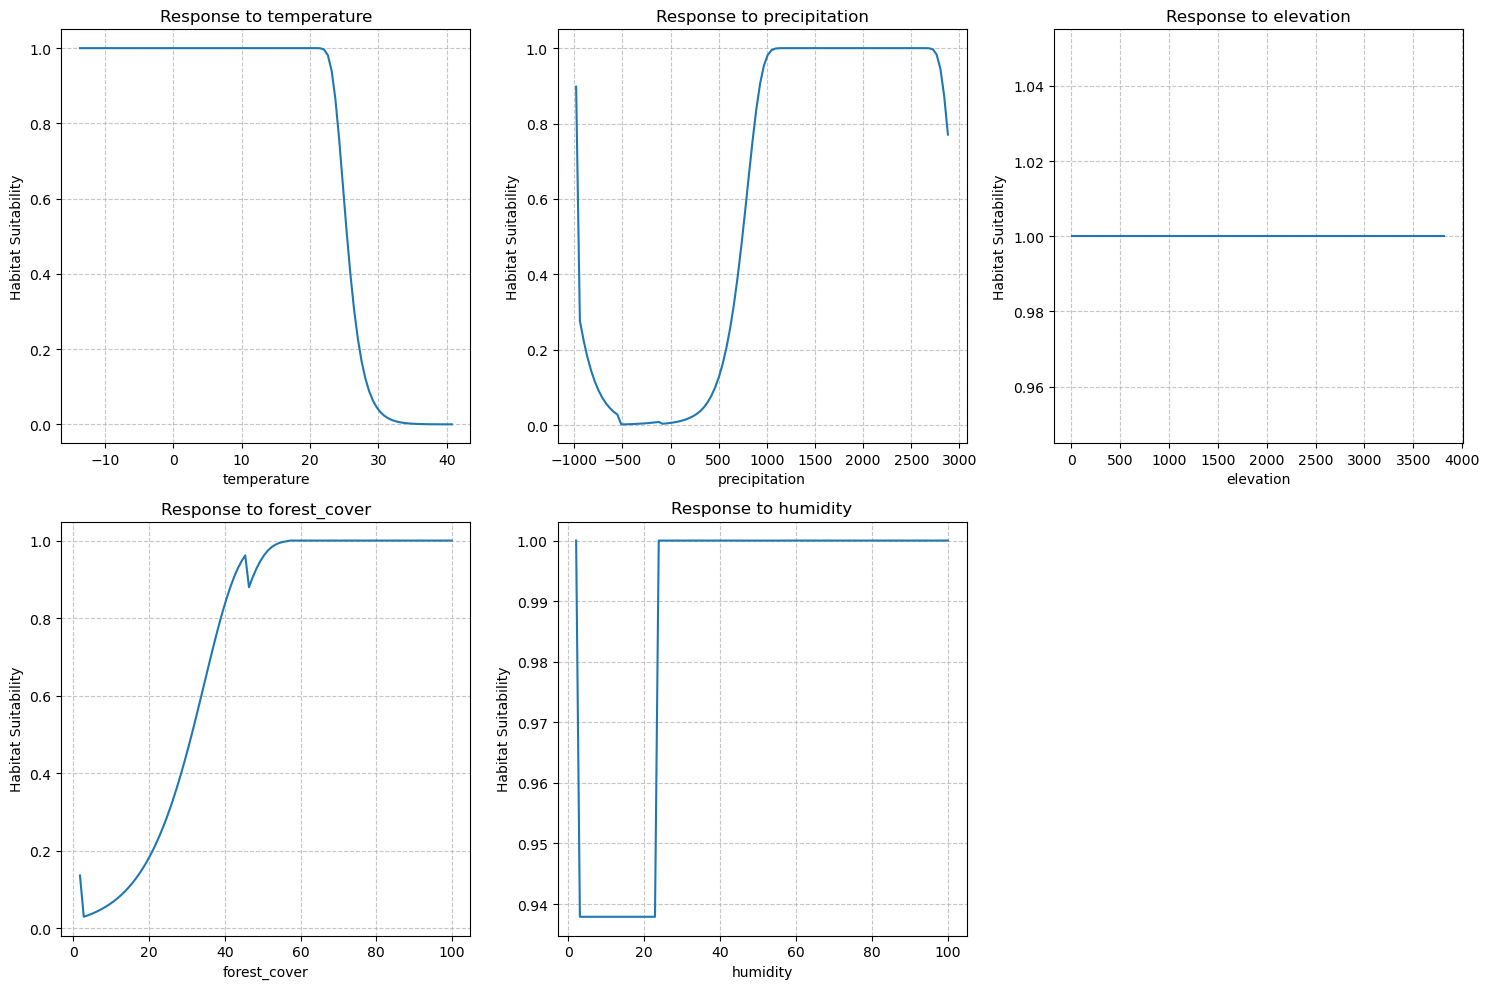

In [16]:
# Create partial dependence plots (response curves)
plt.figure(figsize=(15, 10))

for i, var in enumerate(X.columns):
    plt.subplot(2, 3, i+1)
    
    # Create a grid of values spanning the range of this variable
    x_range = np.linspace(X[var].min(), X[var].max(), 100)
    
    # Create a copy of a sample record that we'll modify
    X_temp = X.iloc[[0]].copy()
    X_temp = X_temp.loc[X_temp.index.repeat(len(x_range))].reset_index(drop=True)
    
    # Modify only the variable we're interested in
    X_temp[var] = x_range
    
    # Generate predictions across this range
    y_partial = model.predict_proba(X_temp)[:, 1]
    
    # Plot the partial dependence
    plt.plot(x_range, y_partial)
    plt.xlabel(var)
    plt.ylabel('Habitat Suitability')
    plt.title(f'Response to {var}')
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

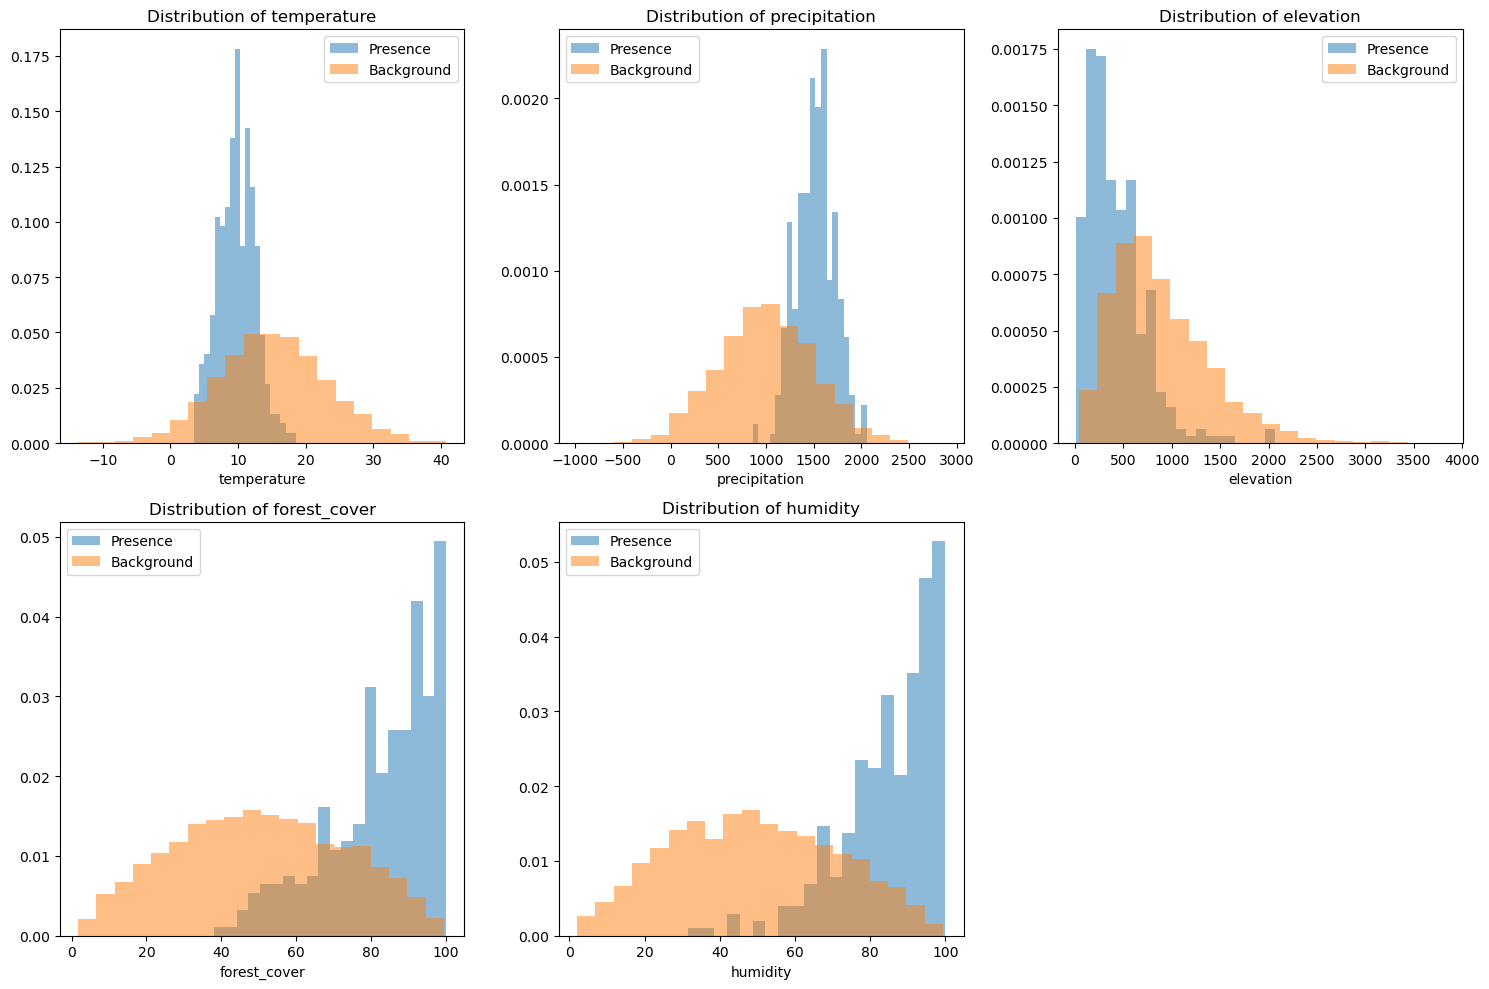

In [17]:
# Plot distribution of environmental variables
plt.figure(figsize=(15, 10))

for i, var in enumerate(X.columns):
    plt.subplot(2, 3, i+1)
    
    # Plot histogram of presence vs background for this variable
    plt.hist(X[var][y == 1], bins=20, alpha=0.5, label='Presence', density=True)
    plt.hist(X[var][y == 0], bins=20, alpha=0.5, label='Background', density=True)
    plt.xlabel(var)
    plt.title(f'Distribution of {var}')
    plt.legend()

plt.tight_layout()